In [1]:
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
from IPython.display import display
from multiprocessing import *
from scipy.stats import norm,circstd,circmean
from scipy.signal import fftconvolve
from ipywidgets import *
import ipywidgets as widgets

In [2]:
__all__ = ['generate_random_mcalpine_et_al_2001_bds']

def fixup(s):
    s = s.replace(',', '.')
    s = s.split('\n')
    s = [map(float, w.split('    ')) for w in s if w]
    f, bitd = zip(*s)
    f = array(f) * kHz
    bitd = array(bitd) * usecond
    return f, bitd

fig_2a_means = '''
0,09455    707,10712
0,16542    520,84442
0,23318    361,37778
0,29635    277,76535
0,35333    232,09654
0,41458    182,66420
0,46000    163,59335
0,51884    205,06943
0,57556    148,14299
0,61844    113,97392
0,68096    147,91190
0,75553    117,48437
0,80553    121,18188
0,99987    109,52809
'''

fig_2a_means_plus_stds = '''
0,09879    1125,42432
0,19757    819,93372
0,30073    604,84766
0,39557    412,23495
0,49462    412,60233
0,59540    333,41052
0,68949    242,79839
0,78939    307,37531
0,89622    250,80063
0,97863    201,73302
1,09955    209,49567
1,23526    228,61478
1,34885    179,54718
1,75320    191,33490
'''
_, mean_bitd = fixup(fig_2a_means)
f, bitd_mean_plus_std = fixup(fig_2a_means_plus_stds)
std_bitd = bitd_mean_plus_std - mean_bitd

def generate_random_mcalpine_et_al_2001_bds(cf, N, std_factor=1.0):
    fmid = 0.5 * (f[1:] + f[:-1])
    I = digitize(cf, fmid)
    mu = mean_bitd[I] * 2 * cf[0] * 180.0
    sigma = std_bitd[I] * std_factor * 2 * cf[0] * 180.0
    x_axis = np.arange(-180, 180, 360.0 / N)

    ##Creating the 2-sided BIPD distribution
    dist_bipd = exp(-(mu - x_axis) ** 2 / (2 * sigma ** 2)) + exp(-(-mu - x_axis) ** 2 / (2 * sigma ** 2))
    dist_bipd = dist_bipd / max(dist_bipd)
    dist_bipd_recentered = np.concatenate((dist_bipd[int(N / 2):int(N)], dist_bipd[0:int(N / 2)]))

    return dist_bipd_recentered

In [67]:
def patt_act_gen(params,f_m,ipd,dyn=False):
    fm=f_m*Hz
    fc=params['f_c']*Hz
    taub=params['tau_b']*ms
    fm_max=64*Hz
    
    # Number of envelope cycles
    n=int(1 + np.ceil(3*taub*fm_max))
    if n % 2 == 0:
        n += 1
    # Time discretization, delta_t=n_t/fm
    t = linspace(0,1,n*params['n_t'])*(1.0*n/fm)
    
    # BIPD discretization, delta_bipd=2*pi/n_bipd
    bipd = linspace(0,2*n*pi,n*params['n_bipd'],endpoint=False)%(2*pi)
    
    # Creating time/bipd 2Dspace
    T, BIPD = meshgrid(t, bipd)
    
    # Stimulus  Envelope 
    A = 0.5*clip(1-params['m']*cos(2*pi*fm*T),0,Inf)
    
    # Converting starting phase to radian.
    dphi_phase_rad=params['dphi_phase']*pi/180.0
    
    # Dynamic or static ipd
    if dyn:
        PHI=(2*pi*fm*T+dphi_phase_rad)%(2*pi)
    else:
        PHI=ipd%(2 * pi)
    # Tuning curve
    TC=(cos((BIPD - PHI) / 2))** params['k']
    
    # modeling the neural activity
    patt_act = TC * A
    
    # Defining borders of the region of interest after convolution
    bipd_inf = int((params['n_bipd'] * n) * ((n - 1) / (2.0 * n)))
    bipd_sup = int((params['n_bipd'] * n) * ((n + 1) / (2.0 * n)))
    t_inf = int(params['n_t'] * n * (1 - 1.0 / n))
    t_sup = int(params['n_t'] * n)
    
    # Producing BIPD distribution based on carrier frequency
    if mcAlp_bipd:
        h_bipd = np.tile(generate_random_mcalpine_et_al_2001_bds([fc], params['n_bipd'], std_factor=1.0), n)
        patt_act_weighted = patt_act*h_bipd[..., np.newaxis]
    else:
        patt_act_weighted = patt_act

    # Setting up the number of neurons participating to the inhibition
    bipd_window = int(params['sigma_k']*params['n_bipd'])
    # delta_t
    pix_t = 1.0/(params['n_t'] * fm)
    #delta_bipd
    pix_bipd = 2*pi/params['n_bipd']
    # Setting up the kernel
    # t-axis
    ksize_t = int(3.*taub/pix_t)
    dt = arange(-ksize_t, ksize_t + 1) * pix_t
    # BIPD axis
    dbipd = arange(-floor(bipd_window/2), floor(bipd_window/2) + 1) * pix_bipd
    DT, DBIPD = meshgrid(dt, dbipd)
    
    kernel0 = where(DT >= 0, 0, exp(DT/taub))

    kernel0[dbipd.shape[0] / 2, :] = 0
    kernel0[:, kernel0.shape[1] / 2] = 0
    
    # Normalization of the kernel
    kernel = kernel0 * pix_t / (1.0 * taub)
   
    # 2D convolution over multiple cycles to remove any border effects
    inh_layer = fftconvolve(patt_act_weighted, kernel[::-1, ::-1], mode='same')
    
    # Crop resulting images to zone of interest, ie the last 2 envelope cycles
    patt_act_weighted_inh= clip(patt_act_weighted - params['gamma'] * inh_layer, 0, inf)
    patt_act = np.concatenate((patt_act[bipd_inf:bipd_sup, t_inf:t_sup], 
                               patt_act[bipd_inf:bipd_sup, t_inf:t_sup]), 1)
    patt_act_weighted = np.concatenate((patt_act_weighted[bipd_inf:bipd_sup, t_inf:t_sup],
                                        patt_act_weighted[bipd_inf:bipd_sup, t_inf:t_sup]), 1)
    patt_act_weighted_inh = np.concatenate((patt_act_weighted_inh[bipd_inf:bipd_sup, t_inf:t_sup],
                                            patt_act_weighted_inh[bipd_inf:bipd_sup, t_inf:t_sup]),1)
    inh_layer = np.concatenate((inh_layer[bipd_inf:bipd_sup, t_inf:t_sup],
                                inh_layer[bipd_inf:bipd_sup, t_inf:t_sup]),1)

    return patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer

In [68]:
def static_ipd_patt_act_gen(params,f_m,ipd,procnum=0,return_dict=None):
    _,_,patt_act_weighted_inh,_,_=patt_act_gen(params,f_m,ipd,dyn=False)
    return_dict[procnum]=patt_act_weighted_inh

In [69]:
def dyn_ipd_patt_act_gen(params,f_m):
    patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer=patt_act_gen(params,f_m,0,dyn=True)
    return patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer

In [70]:
def pointer_ipd(params,multiproc):
    ##Use of multiprocessing to make the generation of the training data faster
    n = 2
    ipds = np.linspace(0, 2 * pi, params['num_static_ipd'], endpoint=False)  
    num_fm = 5
    pointer_ipd_patts = np.zeros((1, num_fm, params['num_static_ipd'], params['n_bipd'], n*params['n_t']))
    proc = []
    manager = Manager()
    return_dict = manager.dict()
    
    #Without multiprocessing
    if not multiproc:
        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                pointer_ipd_patts[i,j,:,:]=static_ipd_patt_act_gen(params,
                                                            2**(i+2),ipds[j])
    else:
    # With multiprocessing
        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                proc.append(Process(target=static_ipd_patt_act_gen, args=(params,2**(i+2),ipds[j],
                i*params['num_static_ipd'] + j,return_dict,)))

        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                proc[i * params['num_static_ipd'] + j].start()

        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                proc[i * params['num_static_ipd'] + j].join()

        for i in xrange(num_fm):
            for j in xrange(params['num_static_ipd']):
                pointer_ipd_patts[:, i, j, :, :] = return_dict[i*params['num_static_ipd'] + j]

    return pointer_ipd_patts

In [71]:
def dyn_ipd(params):

    n = 2
    num_fm = 5
    dyn_ipd_patts = np.zeros((1, num_fm, params['n_bipd'], 2 * params['n_t']))

    for i in xrange(num_fm):
        _,_,dyn_ipd_patts[0, i, :],_,_=dyn_ipd_patt_act_gen(params,2**(i+2))
    return dyn_ipd_patts


In [78]:
def similarity_scoring(params,dyn_ipd_patts,static_ipd_patts,decision_window,width_frame):
    num_fm = 5
    scores = np.zeros((num_fm, params['num_static_ipd']))
    std_scores = np.zeros((num_fm))
    results = np.zeros(num_fm)
    
    #Implementing 2D dot product
    for i in xrange(num_fm):
        for j in xrange(params['num_static_ipd']):
            if np.any(dyn_ipd_patts[i][:, decision_window[0]:decision_window[1]]) and np.any(
                    static_ipd_patts[i, j, :, decision_window[0]:decision_window[1]]):
                scores[i, j] = sum(dyn_ipd_patts[i][:, decision_window[0]:decision_window[1]]
                                   * static_ipd_patts[i, j, :, decision_window[0]:decision_window[1]])
                
                #Normalization of the similarity scores
                scores[i, j] /= (np.linalg.norm(dyn_ipd_patts[i][:, decision_window[0]:decision_window[1]]) *
                                 np.linalg.norm(static_ipd_patts[i, j, :, decision_window[0]:decision_window[1]]))

    # Matching the output IPD to the IPD maximizing the similarity scoring
    # And correcting for phase at t=0
    results = np.argmax(scores, 1) * 360.0 / params['num_static_ipd'] - params['dphi_phase']
    results %= 360
    
    # Computing circular std for each modulation frequency, at the similarity scoring level 
    sum_sin = np.zeros((num_fm))
    sum_cos = np.zeros((num_fm))
    ipds = np.linspace(0, 2 * pi, params['num_static_ipd'], endpoint=False)
    for k in xrange(num_fm):
        for j in xrange(params['num_static_ipd']):
            sum_sin[k] += np.sin(ipds[j] + 0 * params['dphi_phase'] * pi / 180.0) * scores[k, j]
            sum_cos[k] += np.cos(ipds[j] + 0 * params['dphi_phase'] * pi / 180.0) * scores[k, j]
        std_scores[k] = sqrt(-np.log((1.0 / sum(scores[k, :]) ** 2) * (sum_sin[k] ** 2 + sum_cos[k] ** 2))) * 180.0 / pi

    return scores, results, std_scores

In [103]:
def simple_browsing(params,multiproc='off'):
    
    static_ipd_patts = pointer_ipd(params,multiproc)
    dyn_ipd_patts = dyn_ipd(params)
    decision_window_pix = [params['n_t'], 2*params['n_t'] - 1]

    res=similarity_scoring(params, dyn_ipd_patts[0], static_ipd_patts[0], decision_window_pix,
            decision_window_pix[1] - decision_window_pix[0])
    return res,static_ipd_patts,dyn_ipd_patts

In [108]:
def visualization(tau_b,sigma_k,gamma,mcAlp_bipd,dphi_phase,n_t,n_bipd,f_c,num_static_ipd,m,k,index_fm,index_pointer_ipd):
  
    params={'tau_b':tau_b,'sigma_k':sigma_k,'gamma':gamma,'mcAlp_bipd':mcAlp_bipd,
        'dphi_phase':dphi_phase,'n_t':n_t,'n_bipd':n_bipd,'f_c':f_c,
          'num_static_ipd':num_static_ipd,'m':m,'k':k}
    res,static_ipd_patts,dyn_ipd_patts=simple_browsing(params,'on')
  
    ftsize=14
    fm_array=[4,8,16,32,64]*Hz
    num_fm=len(fm_array)
    n=2
    
    dyn_fm=[]
    
    for i in xrange(num_fm):
        dyn_fm.append(dyn_ipd_patt_act_gen(params,2**(i+2)))
    
    fm=2**(index_fm +2)
    
    figure(figsize=(20,14))
    gs = GridSpec(3, 3) 
    
    subplot(gs[0,0])
    title('Network activity, fm =' + str(fm)+'Hz before BIPD weighting',fontsize=ftsize)
    imshow(dyn_fm[index_fm][0],origin='lower left', interpolation='nearest', aspect='auto',extent=[0,500,0,360],cmap='viridis')
    subplot(gs[0,1])
    if mcAlp_bipd==True:
        dist_bipd=generate_random_mcalpine_et_al_2001_bds([f_c]*Hz,n_bipd,std_factor=1.0)
    else:
        dist_bipd=np.ones(n_bipd)

    x_axis= np.arange(0, 360, 360.0/n_bipd)
    title('Distribution of BIPD when fc='+str(f_c)+' Hz',fontsize=ftsize)
    plot(x_axis,dist_bipd)
    xlabel('BIPD (deg)',fontsize=ftsize)
    ylabel('Normalized frequency',fontsize=ftsize)

    subplot(gs[0,2])
    title('Network activity, fm='+ str(fm)+' Hz after BIPD weighting',fontsize=ftsize)
    imshow(dyn_fm[index_fm][1],origin='lower left', interpolation='nearest', aspect='auto',cmap='viridis')
    ylabel('BIPD (deg)',fontsize=ftsize)

    subplot(gs[1,0])
    title('Kernel, fm='+str(fm)+' Hz',fontsize=ftsize)
    imshow(dyn_fm[index_fm][3],origin='lower left', interpolation='nearest', aspect='auto',cmap='viridis')
    ylabel('BIPD (deg)',fontsize=ftsize)

    subplot(gs[1,1])
    title('Inhibition layer, fm='+ str(fm) +'Hz after BIPD weighting',fontsize=ftsize)
    imshow(dyn_fm[index_fm][4],origin='lower left', interpolation='nearest', aspect='auto',extent=[0,2*(1.0/fm),0,360],cmap='viridis')
    xlabel('Time (second)',fontsize=ftsize)
    ylabel('BIPD (deg)',fontsize=ftsize)

    subplot(gs[1,2])
    title('Network activity after subtracting inhibition layer, fm='+ str(fm),fontsize=ftsize)
    imshow(dyn_fm[index_fm][2],origin='lower left', interpolation='nearest', aspect='auto',cmap='viridis')
    ylabel('BIPD (deg)',fontsize=ftsize)
    
    subplot(gs[2,0])
    title('Pointer IPD activity after inhibition, ipd=' + str(index_pointer_ipd*360.0/(num_static_ipd))+'deg, fm=' +str(fm)+' Hz',fontsize=ftsize)
    imshow(static_ipd_patts[0][index_fm,index_pointer_ipd],origin='lower left', interpolation='nearest', aspect='auto',
           extent=[0,2*(1.0/fm),0,360],cmap='viridis')
    xlabel('Time (second)',fontsize=ftsize)
    ylabel('BIPD',fontsize=ftsize)

    subplot(gs[2,1])
    title('Similarity scoring results')
    imshow(transpose(res[0]),origin='lower left', interpolation=None, aspect='auto',
           extent=[4,64,0,360],cmap='viridis')
    ylabel('BIPD (deg)',fontsize=ftsize)
    xlabel('Modulation frequency',fontsize=ftsize)
    
    subplot(gs[2,2])
    title('Phase/fm curve')
    errorbar(fm_array, res[1],yerr=res[2], fmt='-o', label='Population model')
    errorbar(fm_array, [37, 40, 62, 83, 115],yerr=[46, 29, 29, 31,37], fmt='--r', label='Data')
    legend(loc='bottom right')
    grid()
    ylim(0, 360)
    xlabel('Modulation frequency (Hz)',fontsize=ftsize)
    ylabel('Extracted phase (deg)',fontsize=ftsize)
    tight_layout()
    
    show()    

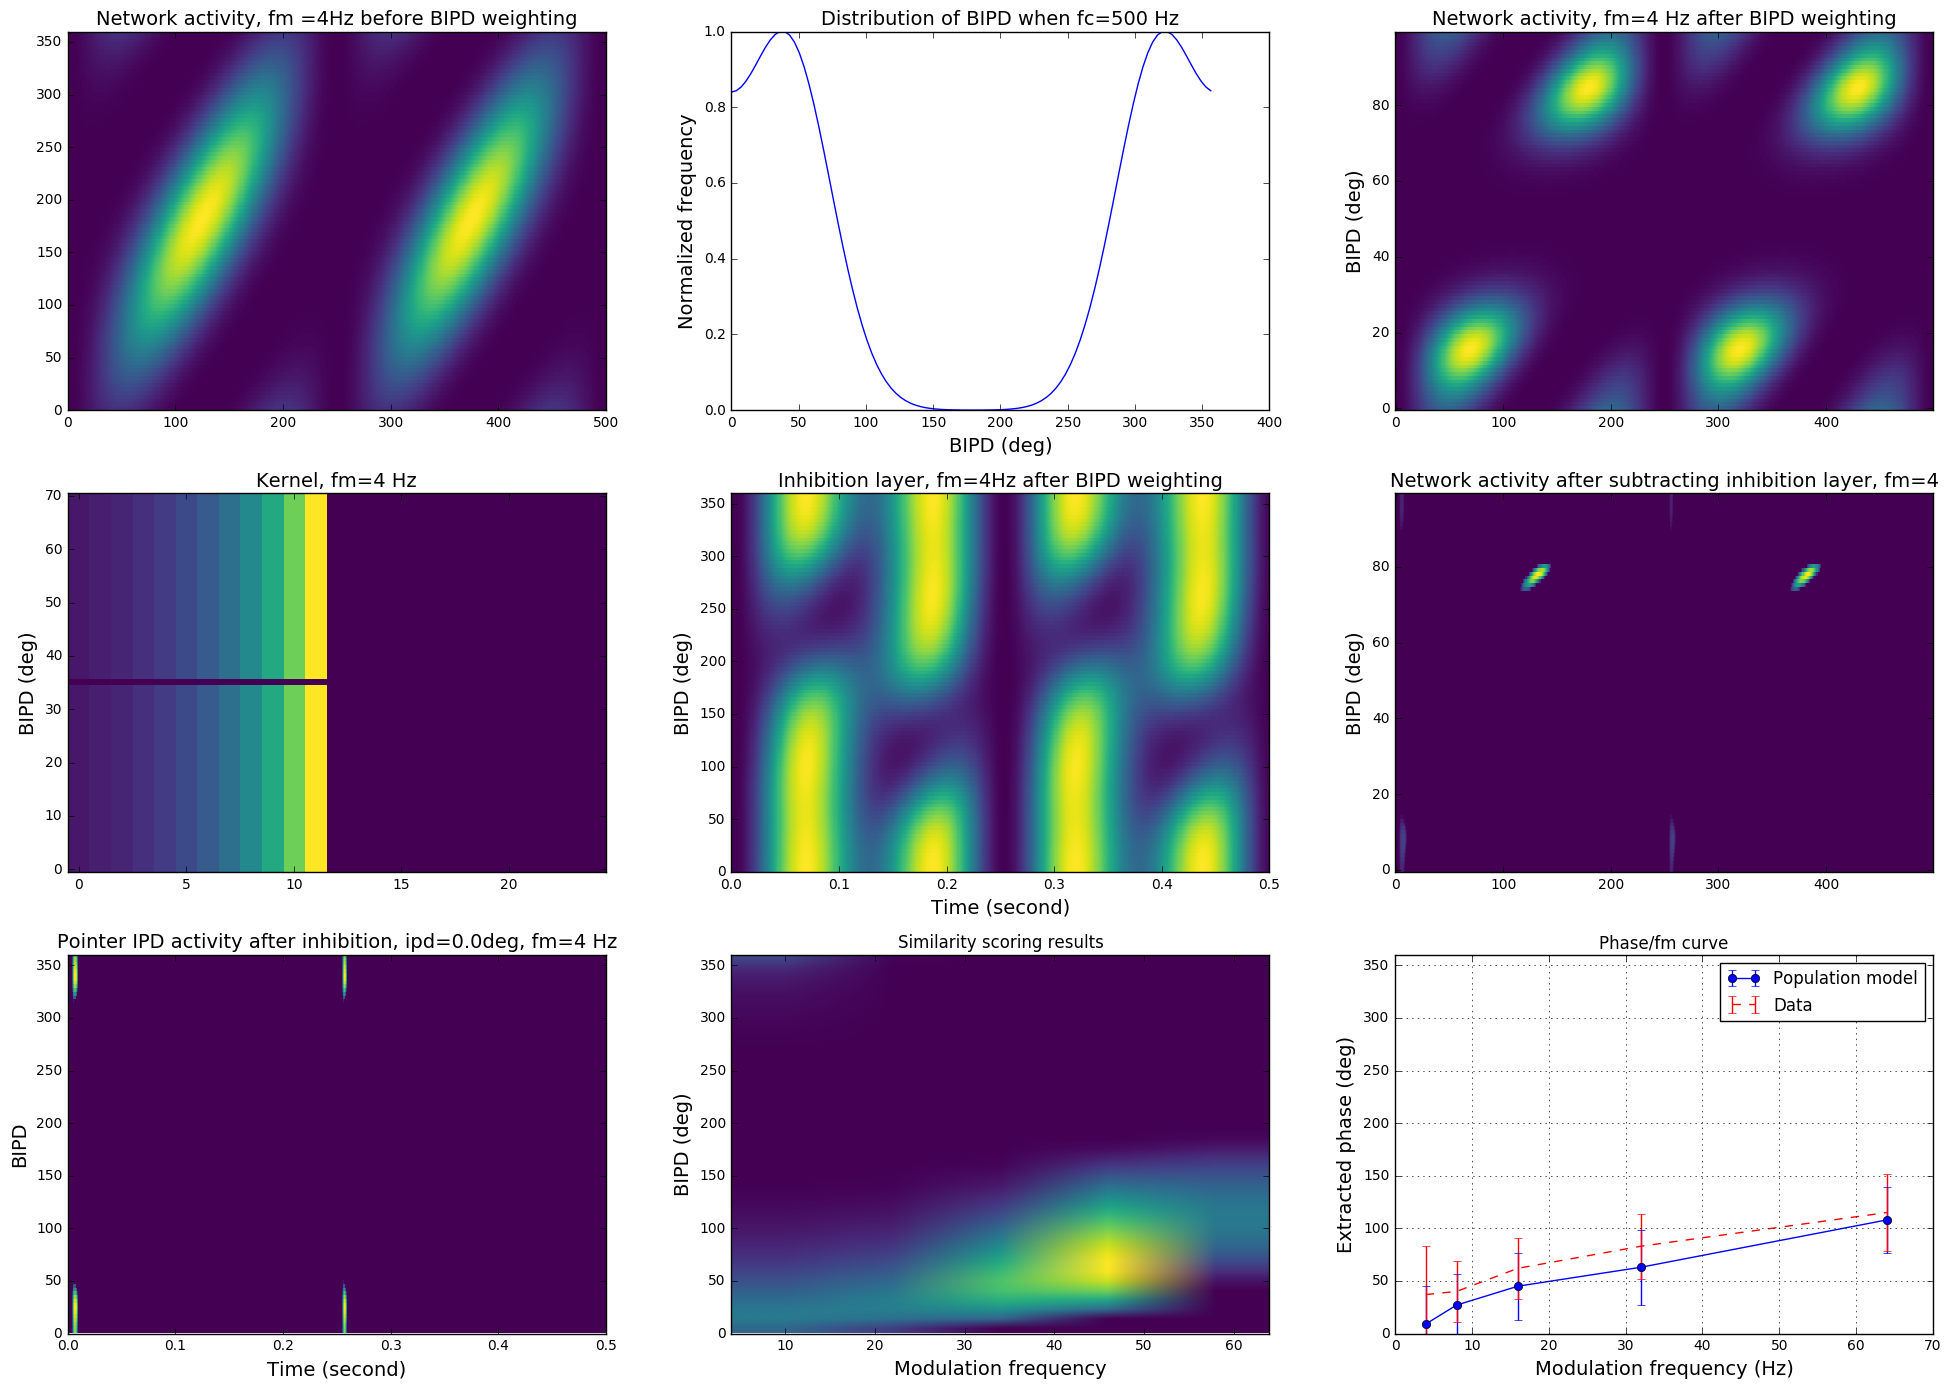

Output()

In [111]:
# model parameters
tau_b=widgets.FloatSlider(min=1, max=10, step=0.1, value=4.0,description='Time constant (ms)')
sigma_k=widgets.FloatSlider(min=0.05,max=1,step=0.05,value=0.7,description='% neurons participating to the inhibition')
gamma=widgets.FloatSlider(min=0,max=0.15,step=0.0025,value=0.08,description='Strength of inhibition')
mcAlp_bipd=widgets.Checkbox(value=True,description='McAlpine distribution BIPD',disabled=False)
dphi_phase=widgets.FloatSlider(min=0, max=360, step=1, value=0,description='Phase difference at t=0 (deg)')
n_t=widgets.IntSlider(min=100, max=1000, step=50, value=250,description='Number of pixels on the time axis')
n_bipd=widgets.IntSlider(min=100, max=1000, step=50, value=100,description='Number of pixels on the BIPD axis')
f_c=widgets.IntSlider(min=0, max=5000, step=100, value=500,description='Carrier frequency (Hz)')
num_static_ipd=widgets.IntSlider(min=10, max=100, step=10, value=40,description='Number of pointer IPD')
m=widgets.FloatSlider(min=0.1, max=2, step=0.1, value=1,description='Synchronization index')
k=widgets.IntSlider(min=0, max=50, step=2, value=4,description='Cosine exponent k')

# additional visualization parameters
index_fm=widgets.IntSlider(min=0, max=4, step=1, value=0,description='Index modulation frequency to display')
index_pointer_ipd=widgets.IntSlider(min=0, max=39, step=1, value=0,description='Training sample') 


vis_params={'tau_b':tau_b,'sigma_k':sigma_k,'gamma':gamma,'mcAlp_bipd':mcAlp_bipd,
            'dphi_phase':dphi_phase,'n_t':n_t,'n_bipd':n_bipd,'f_c':f_c,
            'num_static_ipd':num_static_ipd,'m':m,'k':k,'index_fm':index_fm,
            'index_pointer_ipd':index_pointer_ipd}

def dashboard(accordion):
    for i in xrange(len(accordion.children)):
        accordion.set_title(i,accordion.children[i].description)
        accordion.children[i].layout.width = '100%'
        accordion.children[i].style = {'description_width': '30%'}
        accordion.children[i].continuous_update = False 

net_act_acc =widgets.Accordion(children=[mcAlp_bipd,dphi_phase,n_t,n_bipd,f_c,m,num_static_ipd,index_fm,index_pointer_ipd])
dashboard(net_act_acc)

tuning_curve_acc = widgets.Accordion(children=[k])
dashboard(tuning_curve_acc)

inh_acc = widgets.Accordion(children=[tau_b,sigma_k,gamma])
dashboard(inh_acc)

tab_contents = ['Network activity', 'Tuning curve', 'Inhibition']    
tab=widgets.Tab()    
children=[net_act_acc,tuning_curve_acc,inh_acc]
tab.children=children
for i in range(len(children)):
    tab.set_title(i,tab_contents[i])

w=widgets.interactive_output(visualization,vis_params)   
display(tab,w)


In [127]:
def pop_maps(arr_fc,arr_tau_b, arr_sigma_k,arr_gamma,arr_k,arr_m,arr_dphi_phase):
    num_static_ipd = 40
    mcAlp_bipd= True
    n_t = 250
    n_bipd = 100
    
    res = np.zeros((5,size(arr_fc),size(arr_tau_b),size(arr_sigma_k),
                    size(arr_gamma),size(arr_k),size(arr_m),size(arr_dphi_phase)))
    print res.shape
    cmpt_max = size(res) / 5.0
    print cmpt_max
    cmpt = 0
    for f in xrange(size(arr_fc)):
        for i in xrange(size(arr_tau_b)):
            for j in xrange(size(arr_sigma_k)):
                for l in xrange(size(arr_gamma)):
                    for n in xrange(size(arr_k)):
                        for p in xrange(size(arr_m)):
                            for q in xrange(size(arr_dphi_phase)):
                                params={'tau_b':arr_tau_b[i],'sigma_k':arr_sigma_k[j],'gamma':arr_gamma[l],
                                        'mcAlp_bipd':mcAlp_bipd,'dphi_phase':arr_dphi_phase[q],'n_t':250,
                                        'n_bipd':n_bipd,'f_c':arr_fc[f],'num_static_ipd':num_static_ipd,
                                        'm':arr_m[p],'k':arr_k[n]}
                                        
                                res[:,f,i,j,l,n,p,q] = simple_browsing(params,'on')[0][1]
                                print res[:,f,i,j,l,n,p,q]
                                cmpt+=1
                                print 'Percentage done: '+str(100.0*cmpt/cmpt_max)+'%'
                                
                                
    save('./results.npy', res)
    save('./param_tau_b.npy', arr_tau_b)
    save('./param_sigma_k.npy', arr_sigma_k)
    save('./param_gamma.npy', arr_gamma)
    save('./param_k.npy', arr_k)
    save('./param_m.npy', arr_m)
    save('./param_dphi_phase', arr_dphi_phase)

In [128]:
#Parameters used in the paper
arr_fc=np.array([200,500])
arr_tau_b=np.arange(0.1,10,0.5)
arr_sigma_k=np.arange(0.1,1,0.1)
arr_gamma=np.arange(0,0.15,0.01)
arr_k=np.array([2,4,8])
arr_m=np.array([0.2,0.4,0.6,0.8,0.9,1.0,1.1,1.2,1.4,1.6,1.8])
arr_dphi_phase=np.array([0,45,90,135,180,225,270,315])

#test parameter
arr_fc_test=np.array([500])
arr_tau_b_test=np.array([0.1,0.2])
arr_sigma_k_test=np.array([0.5])
arr_gamma_test=np.array([0.05,0.07])
arr_k_test=np.array([4])
arr_m_test=np.array([1.0])
arr_dphi_phase_test=np.array([0])

pop_maps(arr_fc_test,arr_tau_b_test,arr_sigma_k_test,arr_gamma_test,arr_k_test,arr_m_test,arr_dphi_phase_test) 

(5, 1, 2, 1, 2, 1, 1, 1)
4.0
[180. 180. 180. 180. 225.]
Percentage done: 25.0%
[180. 180. 180. 225. 207.]
Percentage done: 50.0%
[180. 180. 180. 225. 216.]
Percentage done: 75.0%
[180. 180. 225. 207. 189.]
Percentage done: 100.0%
